In [43]:
import os
import re
import glob
import json
from pathlib import Path
from functools import partial
import pandas as pd
import numpy as np

import tifffile
import imageio as iio
import imageio.v3 as iiov3
import cv2

import fastplotlib as fpl
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

import lbm_suite2p_python as lsp
import mbo_utilities as mbo
import dask.array as da
import dask

import suite2p

In [23]:
def read_movie(filepath):
    reader = iio.imiter(filepath)
    sample = next(reader)  # Read a single frame to get shape & dtype

    lazy_arrays = [dask.delayed(iio.imread)(filepath, index=i) for i in range(len(list(iio.imiter(filepath))))]
    lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype) for x in lazy_arrays]

    return da.stack(lazy_arrays, axis=0)
    
def read_movie(filepath):
    reader = iio.get_reader(filepath)
    frames = [frame for frame in reader]
    return np.array(frames)

def match_index(frame_idx: int, num_frames: int, fps: float, num_frames_match: int, fps_match: float) -> int:
    time_sec = frame_idx / fps
    matched_idx = int(np.round(time_sec * fps_match))
    return min(matched_idx, num_frames_match - 1)

def extract_fluorescence_slice(center_idx, f_traces, window_size):
    half_window = window_size // 2
    start_idx = max(0, center_idx - half_window)
    end_idx = min(f_traces.shape[1], center_idx + half_window)

    if end_idx - start_idx < window_size:
        if start_idx == 0:
            end_idx = min(f_traces.shape[1], start_idx + window_size)
        else:
            start_idx = max(0, end_idx - window_size)

    fluorescence_slice = f_traces[:, start_idx:end_idx]

    missing = window_size - fluorescence_slice.shape[1]
    if missing > 0:
        fluorescence_slice = np.pad(fluorescence_slice, ((0, 0), (0, missing)), mode="constant")

    return fluorescence_slice


def normalize_fluorescence(fluorescence_slice):
    return (fluorescence_slice - np.min(fluorescence_slice)) / (np.ptp(fluorescence_slice) + 1e-9)

def get_f(ev, video_data, video_fps, fluorescence_fps, f_traces, playback_speed=0.5, widget=None, calc=None, calcium_data=None):
    if calcium_data is not None:
        pass
    t_frame = ev['t']
    t_sec = (t_frame / video_fps) * (1 / playback_speed)
    window_size = int(10.0 * fluorescence_fps)

    center_idx = match_index(t_frame, video_data.shape[0], video_fps, f_traces.shape[1], fluorescence_fps)
    fluorescence_slice = extract_fluorescence_slice(center_idx, f_traces, window_size)
    fluorescence_norm = normalize_fluorescence(fluorescence_slice)

    viridis = get_cmap("viridis")
    if not widget:
        return fluorescence_norm
    else:
        # widget.data = viridis(fluorescence_norm)[..., :3]
        widget.data = fluorescence_norm
        calc.data = calcium_data[t_frame]

In [33]:
parent_dir = Path(r"D:\W2_DATA\kbarber\2025-02-10\mk303")

behavior_movie_fname = parent_dir.joinpath("raw_video_data", "full_behavioral_camera_converted.mp4")
calcium_movie_fname = parent_dir.joinpath("assembled", "plane_09_demo.tiff")
traces_fname = r"D:\W2_DATA\kbarber\2025-02-10\mk303\results\plane_09_demo\plane0\F.npy"
iscell_fname = r"D:\W2_DATA\kbarber\2025-02-10\mk303\results\plane_09_demo\plane0\iscell.npy"
ops_fname = r"D:\W2_DATA\kbarber\2025-02-10\mk303\results\plane_09_demo\plane0\ops.npy"

# behavior_data_fname = behavior_data_dir.joinpath("raw_behavior_data", "_iblrig_taskData.raw.jsonable")

## Load data

In [34]:
## If you havent loaded/saved this yet
# video_data = read_movie(behavior_movie_fname)
# video_data.shape
# np.save('./videoc.npy', video_data[:10, ...])

## otherwise, just load (may take a while, ~1minute 30 seconds for 40GB movie)
video_data = np.load("./video.npy")

## or, subsample it
# video_data = np.load('./video.npy')[:5000, ...]

In [36]:
calcium_data = tifffile.memmap(calcium_movie_fname)
metadata = mbo.get_metadata(calcium_movie_fname)
calcium_data.shape

(52628, 448, 448)

In [26]:
calcium_fps = metadata["frame_rate"]

In [27]:
traces = np.load(traces_fname)[:600, :15000]
traces.shape

(600, 15000)

In [28]:
fixed_get_f = partial(get_f, video_data=video_data, video_fps=30, fluorescence_fps=metadata['frame_rate'], f_traces=traces, playback_speed=30, widget=None)
init_window = fixed_get_f({"t": 0})
init_window.shape

(600, 170)

In [29]:
output_ops = np.load(ops_fname, allow_pickle=True).item()

cell_fpath = Path(output_ops['save_path']).joinpath('iscell.npy')
stat_fpath = Path(output_ops['save_path']).joinpath('stat.npy')
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)

im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_ops['Ly'], Lx=output_ops['Lx'], label_id=True)
im[im == 0] = np.nan

cell_mask = np.nanmax(im[iscell], axis=0)

In [58]:
spectrogram_plot = fpl.Figure(size=(700, 300), shape=(1, 2))

for subplot in spectrogram_plot:
    subplot.toolbar = False

spec = spectrogram_plot[0, 0].add_image(data=init_window, name="spectrogram")

calc = spectrogram_plot[0, 1].add_image(data=calcium_data[0], name="calcium_data")
# spectrogram_plot[0, 1].add_image(data=cell_mask, name="mask")

select = spectrogram_plot[0,0].graphics[0].add_linear_selector()
select.selection = init_window.shape[1] / 2

video_widget = fpl.ImageWidget(data=[video_data[..., 0]], rgb=[False], figure_kwargs={"size": (700, 360), "shape": (1, 1)}, graphic_kwargs={"vmin": 0, "vmax": 255}, cmap='gray')
fixed_get_f = partial(get_f, video_data=video_data, video_fps=30, fluorescence_fps=metadata['frame_rate'], f_traces=traces, playback_speed=30, widget=spec, calc=calc, calcium_data=calcium_data)
video_widget.add_event_handler(fixed_get_f, "current_index")
video_widget.figure[0,0].toolbar=False
VBox([spectrogram_plot.show(maintain_aspect=False),video_widget.show(),])

RFBOutputContext()

RFBOutputContext()

In [273]:
# spec.data[:].shape
# select.current_index
# spec.figure[0,0].graphics[0].data[0]

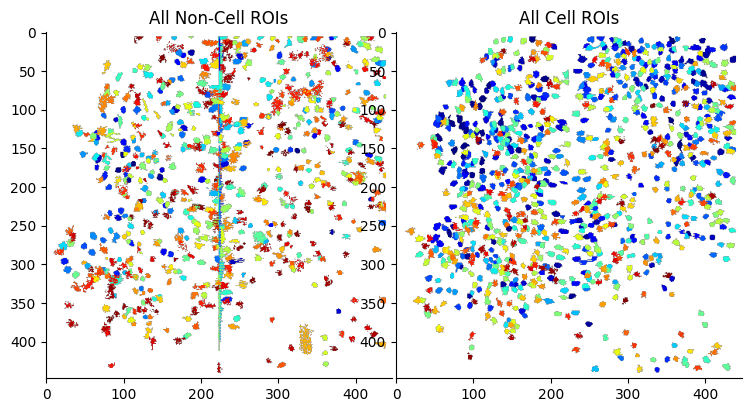

In [290]:
output_ops = np.load(ops_fname, allow_pickle=True).item()

cell_fpath = Path(output_ops['save_path']).joinpath('iscell.npy')
stat_fpath = Path(output_ops['save_path']).joinpath('stat.npy')
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)

im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_ops['Ly'], Lx=output_ops['Lx'], label_id=True)
im[im == 0] = np.nan

plt.subplot(1, 4, 3)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 4, 4)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");

In [272]:
init_window.shape[1] / 2

42.5

In [56]:
iw.close()

1. Loop over each folder containing the date of the recording

- if it is a valid directory with a valid date-timestamp, continue iterating through it

In [46]:
def norm_minmax(images):
    """ Normalize a NumPy array to the range [0, 1]. """
    return (images - images.min()) / (images.max() - images.min())


In [53]:
import ffmpeg

def save_mp4_stream(fname, images, framerate=60, speedup=1, chunk_size=100, cmap="gray",
                    vcodec='libx264', normalize=True, process=None):
    if isinstance(images, (str, Path)):
        if Path(images).is_file():
            images = tifffile.memmap(images)
        else:
            raise FileNotFoundError(f"File not found: {images}")

    T, height, width = images.shape
    colormap = cm.get_cmap(cmap)

    if normalize:
        images = norm_minmax(images)

    output_framerate = int(framerate * speedup)

    if process is None:
        process = (
            ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s=f'{width}x{height}', framerate=output_framerate)
            .output(str(fname), format='mp4', pix_fmt='yuv420p', vcodec=vcodec, r=output_framerate, movflags='+faststart')
            .overwrite_output()
            .run_async(pipe_stdin=True)
        )


    for start in range(0, T, chunk_size):
        end = min(start + chunk_size, T)
        chunk = images[start:end]
        colored_chunk = (colormap(chunk)[:, :, :, :3] * 255).astype(np.uint8)
        for frame in colored_chunk:
            process.stdin.write(frame.tobytes())

    return process


In [48]:
calcium_data.shape

(52628, 448, 448)

In [49]:
images_1 = calcium_data[:2000, ...]
images_2 = calcium_data[2000:4000, ...]
images_list = [images_1, images_2]

In [57]:
from matplotlib import cm

process = None
for i in range(len(images_list)):  # Run 3 times
    process = save_mp4_stream("./output2.mp4", images_list[i], process=process)

process.stdin.close()
process.wait()

0

In [4]:
root_dir = r"\\v-storage2\v-data4\kbarber\IBL_behavioral_2025\february_2025\mk301"
desired_protocol = "_iblrig_tasks_trainingChoiceWorld"
date_protocol_counts = {}
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')
for item in os.listdir(root_dir):
    date_dir = os.path.join(root_dir, item)
    if os.path.isdir(date_dir) and date_pattern.match(item):
        subsession_dirs = [
            d for d in os.listdir(date_dir)
            if os.path.isdir(os.path.join(date_dir, d)) and re.match(r'\d{3}', d)
        ]
        valid_subsessions = 0
        for subsession in subsession_dirs:
            jsonable_path = os.path.join(date_dir, subsession, "raw_behavior_data", "_iblrig_taskData.raw.jsonable")
            if os.path.exists(jsonable_path):
                with open(jsonable_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            try:
                                data = json.loads(line)
                                if data.get("task_protocol") == desired_protocol:
                                    valid_subsessions += 1
                            except json.JSONDecodeError:
                                pass
                            break
        if valid_subsessions > 0:
            date_protocol_counts[item] = valid_subsessions

if date_protocol_counts:
    total_sessions = len(date_protocol_counts)
    print("Dates (sessions) with protocol", desired_protocol, "and the number of subsessions found:")
    for date, count in sorted(date_protocol_counts.items()):
        print(f"Date: {date}  -->  Subsession count: {count}")
    print(f"\nTotal sessions with the desired protocol: {total_sessions}")
else:
    print("No date folders with the desired protocol were found.")


Dates (sessions) with protocol _iblrig_tasks_trainingChoiceWorld and the number of subsessions found:
Date: 2025-02-03  -->  Subsession count: 1
Date: 2025-02-04  -->  Subsession count: 1
Date: 2025-02-05  -->  Subsession count: 1
Date: 2025-02-07  -->  Subsession count: 1
Date: 2025-02-08  -->  Subsession count: 1
Date: 2025-02-09  -->  Subsession count: 1
Date: 2025-02-10  -->  Subsession count: 1
Date: 2025-02-13  -->  Subsession count: 1
Date: 2025-02-14  -->  Subsession count: 1
Date: 2025-02-15  -->  Subsession count: 1
Date: 2025-02-16  -->  Subsession count: 1

Total sessions with the desired protocol: 11


Concatenate all raw data files into single data frame

In [5]:
def extract_trial_data(trial_data):
    trial_dict = {}
    # Extract top-level keys
    for key in ['stim_gain', 'reward_amount', 'trial_num', 'block_num', 'block_trial_num', 
                'block_len', 'stim_probability_left', 'position', 'contrast', 
                'current_contrast', 'elapsed_time', 'response_time', 
                'trial_correct', 'ntrials_correct']:
        trial_dict[key] = trial_data.get(key, None)
        
    # Extract behavior_data timestamps (if present)
    if 'behavior_data' in trial_data:
        behavior_data = trial_data['behavior_data']
        trial_dict['Bpod_start_timestamp'] = behavior_data.get('Bpod start timestamp', None)
        trial_dict['Trial_start_timestamp'] = behavior_data.get('Trial start timestamp', None)
        trial_dict['Trial_end_timestamp'] = behavior_data.get('Trial end timestamp', None)
        
        # Extract state timestamps if available
        if 'States timestamps' in behavior_data:
            states = behavior_data['States timestamps']
            for state_key in ['stim_on', 'closed_loop', 'reward', 'error', 'exit_state']:
                value1 = None
                value2 = None
                if state_key in states and states[state_key]:
                    first_val = states[state_key][0]
                    if isinstance(first_val, list) and len(first_val) == 2:
                        value1, value2 = first_val
                    else:
                        try:
                            value1 = first_val[0]
                        except (TypeError, IndexError):
                            value1 = first_val
                trial_dict[f"{state_key}1"] = value1
                trial_dict[f"{state_key}2"] = value2
    else:
        trial_dict['Bpod_start_timestamp'] = None
        trial_dict['Trial_start_timestamp'] = None
        trial_dict['Trial_end_timestamp'] = None
        for state_key in ['stim_on', 'closed_loop', 'reward', 'error', 'exit_state']:
            trial_dict[f"{state_key}1"] = None
            trial_dict[f"{state_key}2"] = None
            
    return trial_dict

# Get the mouse ID from the basename of the input directory
mouse_id = os.path.basename(os.path.normpath(root_dir))

# List to collect all trial data across sessions and subsessions
all_trials = []

# Iterate over date folders (sessions)
for date_folder in sorted(os.listdir(root_dir)):
    date_path = os.path.join(root_dir, date_folder)
    if os.path.isdir(date_path) and date_pattern.match(date_folder):
        # Look for subsession folders (e.g., "001", "002", etc.)
        subsession_dirs = [d for d in os.listdir(date_path) 
                           if os.path.isdir(os.path.join(date_path, d)) and re.match(r'\d{3}', d)]
        for subsession in sorted(subsession_dirs):
            # Note: Using "raw_behavior_data" here to match Cell 2
            jsonable_path = os.path.join(date_path, subsession, "raw_behavior_data", "_iblrig_taskData.raw.jsonable")
            if os.path.exists(jsonable_path):
                # Check if the file qualifies (i.e. contains the desired protocol)
                qualifies = False
                with open(jsonable_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            try:
                                data = json.loads(line)
                                if data.get("task_protocol") == desired_protocol:
                                    qualifies = True
                            except json.JSONDecodeError:
                                pass
                            break  # Only check the first nonempty line
                # If the file qualifies, process each trial in the file
                if qualifies:
                    with open(jsonable_path, 'r') as f:
                        for line in f:
                            if line.strip():
                                try:
                                    trial_data = json.loads(line)
                                    # Extract trial details using the helper function
                                    trial_dict = extract_trial_data(trial_data)
                                    # Add additional metadata columns:
                                    trial_dict['date'] = date_folder           # session date
                                    trial_dict['subsession'] = subsession        # subsession folder name (e.g., "001")
                                    trial_dict['mouse_id'] = mouse_id
                                    all_trials.append(trial_dict)
                                except json.JSONDecodeError:
                                    print(f"Error decoding JSON in file {jsonable_path}")

# Create a DataFrame from the collected trial data
if all_trials:
    df_all = pd.DataFrame(all_trials)
    
    # Convert the date column to datetime for proper sorting
    df_all['date'] = pd.to_datetime(df_all['date'])
    df_all = df_all.sort_values(by=['date', 'subsession'])
    # Convert the date column back to string format (ISO format)
    df_all['date'] = df_all['date'].dt.strftime('%Y-%m-%d')
    
    # Create a numeric session number based on unique dates (each date gets a new number)
    unique_dates = sorted(df_all['date'].unique())
    session_map = {date: idx+1 for idx, date in enumerate(unique_dates)}
    df_all['session'] = df_all['date'].map(session_map)
    
    # Reorder columns: mouse_id, date, session, subsession, then the rest
    current_cols = list(df_all.columns)
    fixed_order = ['mouse_id', 'date', 'session', 'subsession']
    other_cols = [col for col in current_cols if col not in fixed_order]
    new_order = fixed_order + other_cols
    df_all = df_all[new_order]
    
    # Define an output CSV filename (saved in the mouse directory)
    output_csv = os.path.join(root_dir, f"{mouse_id}_unified_behavior.csv")
    df_all.to_csv(output_csv, index=False)
    print(f"Unified CSV saved to: {output_csv}")
else:
    print("No trial data found for the desired protocol.")

Unified CSV saved to: \\v-storage2\v-data4\kbarber\IBL_behavioral_2025\february_2025\mk301\mk301_unified_behavior.csv


Generate session average statistics

In [6]:
import os
import pandas as pd

# Define the path to the unified CSV file (adjust as needed)
csv_file = os.path.join(root_dir, f"{mouse_id}_unified_behavior.csv")
df = pd.read_csv(csv_file)

# Convert columns to appropriate types
df['trial_correct'] = df['trial_correct'].astype(str).str.lower() == 'true'
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['current_contrast'] = pd.to_numeric(df['current_contrast'], errors='coerce')
df['response_time'] = pd.to_numeric(df['response_time'], errors='coerce')

# Group data by session
grouped = df.groupby('session')

# Helper function to compute percentage of trials correct in a subset
def compute_pct(df_sub):
    if len(df_sub) == 0:
        return None
    else:
        return df_sub['trial_correct'].mean() * 100

# Compute summary statistics per session using a lambda on each group
summary_stats = grouped.apply(lambda g: pd.Series({
    "session_date": g['date'].iloc[0],
    # 1) Percentage of total trials where trial_correct is True
    "Pct_total_trial_correct": g['trial_correct'].mean() * 100,
    # 2) Percentage of trials (of those with position==35 and current_contrast==1) where trial_correct is True
    "Pct_pos35_contrast1_correct": compute_pct(g[(g['position'] == 35) & (g['current_contrast'] == 1)]),
    # 3) Percentage of trials (of those with position==-35 and current_contrast==1) where trial_correct is True
    "Pct_neg35_contrast1_correct": compute_pct(g[(g['position'] == -35) & (g['current_contrast'] == 1)]),
    # 4) Percentage of trials (of those with position==35 and current_contrast==0.25) where trial_correct is True
    "Pct_pos35_contrast0.25_correct": compute_pct(g[(g['position'] == 35) & (g['current_contrast'] == 0.25)]),
    # 5) Percentage of trials (of those with position==-35 and current_contrast==0.25) where trial_correct is True
    "Pct_neg35_contrast0.25_correct": compute_pct(g[(g['position'] == -35) & (g['current_contrast'] == 0.25)]),
    # 6) Average response_time for all trials in the session
    "Avg_response_time": g['response_time'].mean(),
    # 7) Average response_time when position == 35 and current_contrast == 1
    "Avg_rt_pos35_contrast1": g.loc[(g['position'] == 35) & (g['current_contrast'] == 1), 'response_time'].mean(),
    # 8) Average response_time when position == -35 and current_contrast == 1
    "Avg_rt_neg35_contrast1": g.loc[(g['position'] == -35) & (g['current_contrast'] == 1), 'response_time'].mean(),
    # 9) Average response_time when position == 35 and current_contrast == 0.25
    "Avg_rt_pos35_contrast0.25": g.loc[(g['position'] == 35) & (g['current_contrast'] == 0.25), 'response_time'].mean(),
    # 10) Average response_time when position == -35 and current_contrast == 0.25
    "Avg_rt_neg35_contrast0.25": g.loc[(g['position'] == -35) & (g['current_contrast'] == 0.25), 'response_time'].mean()
}))

# Reset the index so that 'session' becomes a column
summary_stats = summary_stats.reset_index()

# Save the summary statistics to a new CSV file in the mouse directory
stats_csv = os.path.join(root_dir, f"{mouse_id}_session_statistics.csv")
summary_stats.to_csv(stats_csv, index=False)
print(f"Session-level statistics saved to: {stats_csv}")




Session-level statistics saved to: \\v-storage2\v-data4\kbarber\IBL_behavioral_2025\february_2025\mk301\mk301_session_statistics.csv


C:\Users\RBO\AppData\Local\Temp\ipykernel_12748\2623262486.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_stats = grouped.apply(lambda g: pd.Series({


Compute trial rolling average for performance and response times

In [17]:
# Cell X: Compute 50-trial rolling average for statistics and output a CSV

# Define the path to the unified CSV file (adjust as needed)
csv_file = os.path.join(root_dir, f"{mouse_id}_unified_behavior.csv")
df = pd.read_csv(csv_file)

# Ensure the DataFrame is sorted in the order trials were run.
# Here we assume the CSV is already sorted by date, session, and trial order.
# Optionally, if you have a trial number column, you can sort by that as well:
# df = df.sort_values(by=['date', 'session', 'trial_num'])

# Convert columns to appropriate types
df['trial_correct'] = df['trial_correct'].astype(str).str.lower() == 'true'
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['current_contrast'] = pd.to_numeric(df['current_contrast'], errors='coerce')
df['response_time'] = pd.to_numeric(df['response_time'], errors='coerce')

# Define a helper function to compute statistics on a DataFrame window
def compute_window_stats(window):
    stats = {}
    # 1) Overall percentage of correct trials in the window
    stats['Pct_total_trial_correct'] = window['trial_correct'].mean() * 100
    
    # For conditions, calculate the percentage among trials that meet the condition.
    def pct_condition(cond_df):
        if len(cond_df) == 0:
            return np.nan
        else:
            return cond_df['trial_correct'].mean() * 100
    
    stats['Pct_pos35_contrast1_correct'] = pct_condition(window[(window['position'] == 35) & 
                                                                  (window['current_contrast'] == 1)])
    stats['Pct_neg35_contrast1_correct'] = pct_condition(window[(window['position'] == -35) & 
                                                                  (window['current_contrast'] == 1)])
    stats['Pct_pos35_contrast0.25_correct'] = pct_condition(window[(window['position'] == 35) & 
                                                                     (window['current_contrast'] == 0.25)])
    stats['Pct_neg35_contrast0.25_correct'] = pct_condition(window[(window['position'] == -35) & 
                                                                     (window['current_contrast'] == 0.25)])
    
    # 6) Overall average response time
    stats['Avg_response_time'] = window['response_time'].mean()
    
    # 7-10) Average response times under conditions (if no matching trials, result is NaN)
    def avg_rt_condition(cond_df):
        if len(cond_df) == 0:
            return np.nan
        else:
            return cond_df['response_time'].mean()
    
    stats['Avg_rt_pos35_contrast1'] = avg_rt_condition(window[(window['position'] == 35) & 
                                                              (window['current_contrast'] == 1)])
    stats['Avg_rt_neg35_contrast1'] = avg_rt_condition(window[(window['position'] == -35) & 
                                                              (window['current_contrast'] == 1)])
    stats['Avg_rt_pos35_contrast0.25'] = avg_rt_condition(window[(window['position'] == 35) & 
                                                                 (window['current_contrast'] == 0.25)])
    stats['Avg_rt_neg35_contrast0.25'] = avg_rt_condition(window[(window['position'] == -35) & 
                                                                 (window['current_contrast'] == 0.25)])
    
    return pd.Series(stats)

# Compute rolling averages with a window size of 50 trials.
# For each trial index, the window will include the current trial and the previous 49 (or fewer for early rows).
rolling_stats_list = []
window_size = 50

for i in range(len(df)):
    # For early trials, use all available trials (min_periods = i+1)
    start_idx = 0 if i < window_size - 1 else i - window_size + 1
    window = df.iloc[start_idx:i+1]
    stats = compute_window_stats(window)
    
    # Optionally add identifiers for the current trial
    stats['trial_index'] = i
    # Include the current trial's metadata (date and session) for reference:
    stats['date'] = df.iloc[i]['date'] if 'date' in df.columns else np.nan
    stats['session'] = df.iloc[i]['session'] if 'session' in df.columns else np.nan
    rolling_stats_list.append(stats)

# Combine rolling window statistics into a DataFrame
rolling_df = pd.DataFrame(rolling_stats_list)

# Optional: Rearrange columns to put trial_index, date, session at the front
cols_order = ['trial_index', 'date', 'session',
              'Pct_total_trial_correct',
              'Pct_pos35_contrast1_correct',
              'Pct_neg35_contrast1_correct',
              'Pct_pos35_contrast0.25_correct',
              'Pct_neg35_contrast0.25_correct',
              'Avg_response_time',
              'Avg_rt_pos35_contrast1',
              'Avg_rt_neg35_contrast1',
              'Avg_rt_pos35_contrast0.25',
              'Avg_rt_neg35_contrast0.25']
rolling_df = rolling_df[cols_order]

# Save the rolling statistics to a new CSV file in the mouse directory
rolling_csv = os.path.join(root_dir, f"{mouse_id}_rolling_statistics.csv")
rolling_df.to_csv(rolling_csv, index=False)
print(f"50-trial rolling average statistics saved to: {rolling_csv}")

50-trial rolling average statistics saved to: /Volumes/v-data4/kbarber/IBL_behavioral_2025/february_2025/mk301/mk301_rolling_statistics.csv


In [ ]:
import shutil
from pathlib import Path

def copy_png_files(filepaths, save_path):
    """
    Copies a list of PNG files to a specified directory.

    Parameters
    ----------
    filepaths : list of str or Path
        List of file paths to PNG files.
    save_path : str or Path
        Directory where the PNG files will be copied.

    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    for file in filepaths:
        file = Path(file)
        if file.suffix.lower() == ".png" and file.exists():
            shutil.copy(file, save_path / file.name)